# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tueplots import bundles
from dataclasses import dataclass
from scipy.optimize import curve_fit

In [2]:
# Group Constants
MALE = 'male'
FEMALE = 'female'
SEX_CATEGORIES = [MALE, FEMALE]

# Intervention Constants
CONTROL_GROUP = 'None'
ALL_GROUP = 'All'
ONE_REMOVED_PREFIX = 'no_'

# Dataset Contsants
DATASET_DIRECTORY = os.path.join('..', 'dat', 'RMR_data')

# tueplots settings
COL_STATE = 'full'  #Set to 'half' for the plot in the paper, 'full' for better analysis of the data
NROWS = 1
NCOLS = 1
USE_LATEX = False    #df: Somehow it doesn't work when USE_LATEX is True because "RuntimeError: Failed to process string with tex because latex could not be found". DIY

plt.rcParams.update(bundles.icml2022(column=COL_STATE, nrows=NROWS, ncols=NCOLS, usetex=USE_LATEX))

# Graphing constants
COLOR_MAP = ["#ADD8E6", "#008000", "#FFD700", "#800080", "#FF7F50", "#40E0D0", "#708090", "#FF8C00", "#FF00FF", "#008080"]

### Parsing the data
In this section we take the extracted values of the robust mouse rejuvination study and wrangle the data into the format needed for modeling the data.

In [3]:
dataset_paths = os.listdir(DATASET_DIRECTORY)

def convert_filename_to_key(filename, category):
    category_removed = filename[len(category) + 1:]
    return os.path.splitext(category_removed)[0]

def create_dataset_mapping(dataset_directory, categories):
    dataset_mappings = {}
    
    for category in categories:
        category_path = {} 
        for path in dataset_paths:
            full_path = os.path.join(dataset_directory, path)
    
            if category == path[:len(category)]:
                key = convert_filename_to_key(path, category)
                category_path[key] = full_path
        dataset_mappings[category] = category_path
    
    return dataset_mappings

In [4]:
def is_one_removed_intervention(key):
    if len(key) < 3:
        return False

    return key[:len(ONE_REMOVED_PREFIX)] == ONE_REMOVED_PREFIX

def extract_single_interventions(dataset_mapping: dict):
    single_interventions = []
    for key in dataset_mapping.keys():
        if key == ALL_GROUP:
            continue
        elif key == CONTROL_GROUP:
            continue
        elif is_one_removed_intervention(key):
            continue
        else:
            single_interventions.append(key)
    
    return single_interventions

def create_one_removed_key(key: str, intervention_list: []) -> []:
    removed_key = key[len(ONE_REMOVED_PREFIX):]

    removed_intervention_list = []
    for intervention in intervention_list:
        if intervention != removed_key:
            removed_intervention_list.append(intervention)

    return removed_intervention_list

def create_intervention_list_from_group(key: str, intervention_list: []):
    new_intervention_list = None
    
    if key == ALL_GROUP:
        new_intervention_list = intervention_list
    elif key == CONTROL_GROUP:
        new_intervention_list = []
    elif is_one_removed_intervention(key):
        new_intervention_list = create_one_removed_key(key, intervention_list)
    else:
        new_intervention_list = [key]

    return ','.join(new_intervention_list)

In [5]:
def load_csv(path):
    return pd.read_csv(
                        path,
                        skiprows=0,
                        sep=',',
                        engine='python',
                        decimal='.',
                        dtype={'x': 'float64', 'y': 'float64'}
            )


def create_dataset_by_category(category_path: dict, single_interventions: []):
    datasets = {}
    for key, path in category_path.items():
        new_key = create_intervention_list_from_group(key, single_interventions)
        datasets[new_key] = load_csv(path)
    return datasets

dataset_mapping = create_dataset_mapping(DATASET_DIRECTORY, SEX_CATEGORIES)
female_dataset_paths = dataset_mapping[FEMALE]
female_single_interventions = extract_single_interventions(female_dataset_paths)

female_dataset = create_dataset_by_category(female_dataset_paths, female_single_interventions)

In [6]:
def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)

@dataclass
class GompertzParameters:
    alpha: np.float64
    beta: np.float64

    @staticmethod
    def from_sequence(seq):
        return GompertzParameters(alpha=seq[0], beta=seq[1])

    def to_tuple(self):
        return (self.alpha, self.beta)

    def __str__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'

    def __repr__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'


DEFAULT_INITIAL_PARAMETERS = GompertzParameters(alpha=0.1, beta=0.085)

def fit_gompertz_model(ages: pd.DataFrame,
                       mortality_rate: pd.DataFrame,
                       initial_parameters: GompertzParameters = DEFAULT_INITIAL_PARAMETERS,
                       max_fit_iterations: int = 2_500) -> GompertzParameters:
    p0 = initial_parameters.to_tuple()
    predicted_parameters, covariance = curve_fit(gompertz, ages, mortality_rate, p0=p0, maxfev=max_fit_iterations)
    return GompertzParameters.from_sequence(predicted_parameters)

test_dataset = female_dataset['HSCs']

def calculate_ages(dataset):
    return np.array(dataset.x) / 365 # ages in years

def calculate_mortality_rate(dataset):
    return np.array(1 - dataset.y)

def fit(dataset):
    ages = calculate_ages(dataset)
    mortality_rate = calculate_mortality_rate(dataset)
    
    predicted_parameters = fit_gompertz_model(ages, mortality_rate)
    predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)
    return predicted_mortality

In [7]:
def plot_fitted_gompertz_curve(ages, mortality_rate, all_mortality_rate, single_mortality_rate, title: str) -> None:
    plt.scatter(ages, mortality_rate, label='Observed Data', color=COLOR_MAP[0])
    plt.plot(ages, predicted_mortality, label='All Gompertz Fit', color=COLOR_MAP[1])
    plt.plot(ages, single_mortality_rate, label='Single Gompertz Fit', color=COLOR_MAP[2])
    plt.xlabel('Age of Mice (Years)')
    plt.ylabel(f'Mortality Rate ({title})')
    plt.legend()
    plt.show()

# Multi-Layer Perceptron

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.nn.functional as F

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
        self.softpluts = nn.Softplus()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.elu(x)
        x = self.fc2(x)
        return x

class MortalityDataset(Dataset):
    def __init__(self, data_dict, samples):
        self.samples = samples

        for treatment_key, treatment_data in data_dict.items():
            age_values = treatment_data['x'].values
            mortality_rates = 1 - treatment_data['y'].values
            treatment_vector = self.create_treatment_vector(treatment_key)

            for age, mortality_rate in zip(age_values, mortality_rates):
                sample = {
                    'input': torch.tensor([age] + treatment_vector, dtype=torch.float32),
                    'output': torch.tensor([mortality_rate], dtype=torch.float32)
                }
                self.samples.append(sample)

    def create_treatment_vector(self, treatment_key):
        # Create a binary treatment vector for each treatment
        all_treatments = ['Rapamycin', 'HSCs', 'Gal-Nav', 'mTERT']
        treatment_vector = [1 if t in treatment_key else 0 for t in all_treatments]
        return treatment_vector

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Create the dataset
mortality_dataset = MortalityDataset(data_dict = female_dataset, samples = [])

# Create a DataLoader without batching as the data isnt too big
data_loader = DataLoader(mortality_dataset, batch_size=len(mortality_dataset), shuffle=True)

In [9]:
from sklearn.model_selection import train_test_split
def train_model(seed, epochs):
    # Model parameters
    input_size = 5  # Age + Treatment vector size
    hidden_size = 64
    output_size = 1
    learning_rate = 0.01
    num_epochs = epochs
    
    # Set a manual seed for PyTorch
    torch.manual_seed(seed)

    # If using a GPU, and want to make things as deterministic as possible
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
        # Below settings are important for reproducibility, but can degrade performance
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    # Set a seed for NumPy
    np.random.seed(seed)
    
    # Initialize model, loss function, and optimizer
    model = MLPModel(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Split the dataset into training and validation sets
    train_data, val_data = train_test_split(mortality_dataset.samples, test_size=0.2, random_state=seed)
    
    # Create separate datasets for training and validation
    train_dataset = MortalityDataset(data_dict= {},samples=train_data)
    val_dataset = MortalityDataset(data_dict= {},samples=val_data)
    
    # Create separate DataLoaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    
    # Training loop
    best_val_loss = float('inf')  # Initialize with a large value
    best_model = None
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for batch in train_loader:
            inputs = batch['input']
            outputs = batch['output']
    
            # Forward pass
            predictions = model(inputs)
            # Compute loss
            loss = criterion(predictions, outputs)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # Validation
        with torch.no_grad():
            val_loss = 0.0
            for val_batch in val_loader:
                val_inputs = val_batch['input']
                val_targets = val_batch['output']
    
                val_predictions = model(val_inputs)
                val_loss += criterion(val_predictions, val_targets)
    
        # Calculate average validation loss
        val_loss /= len(val_loader)
    
        # Print the loss for each epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')
    
        # Check if the current model has the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
    # Use the best model (lowest val loss) for inference
    model.load_state_dict(best_model)
    return [model, best_val_loss]

trained_model = train_model(42,10000)
model = trained_model[0]

Epoch 1/10000, Loss: 1903.534423828125, Val Loss: 3266.474853515625
Epoch 2/10000, Loss: 3219.505615234375, Val Loss: 1103.5323486328125
Epoch 3/10000, Loss: 1087.8018798828125, Val Loss: 0.45978081226348877
Epoch 4/10000, Loss: 0.4638766646385193, Val Loss: 502.3649597167969
Epoch 5/10000, Loss: 494.9070129394531, Val Loss: 910.2059936523438
Epoch 6/10000, Loss: 896.791259765625, Val Loss: 672.0414428710938
Epoch 7/10000, Loss: 662.1339111328125, Val Loss: 242.45277404785156
Epoch 8/10000, Loss: 238.8577423095703, Val Loss: 13.302997589111328
Epoch 9/10000, Loss: 13.100343704223633, Val Loss: 46.60525894165039
Epoch 10/10000, Loss: 45.95762252807617, Val Loss: 197.9466552734375
Epoch 11/10000, Loss: 195.1189422607422, Val Loss: 303.9610900878906
Epoch 12/10000, Loss: 299.59716796875, Val Loss: 294.5418701171875
Epoch 13/10000, Loss: 290.30950927734375, Val Loss: 194.01922607421875
Epoch 14/10000, Loss: 191.2266082763672, Val Loss: 76.83393096923828
Epoch 15/10000, Loss: 75.73267364501

In [10]:
def plot_model_result(model, age, treatment, ax=None):
    predictions = make_predictions(model, age, treatment)
    ages_plot = age / 365

    # Check if an axis is provided, if not, create a new subplot
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the predicted mortality rates
    ax.scatter(ages_plot, predictions, label='Predicted Mortality Rate', color=COLOR_MAP[0])
    ax.set_xlabel('Age of Mice (Years)')
    ax.set_ylabel('Predicted Mortality Rate')
    ax.set_title('Predicted Mortality Rates for Treatment Combination ' + str(treatment))
    ax.legend()

    # If an axis was created inside the function, show the plot
    if ax is None:
        plt.show()
        
def make_predictions(model, ages, treatment):
    input_data = []
    for age in ages:
        treatment_vector = treatment
        sample = {
            'input': torch.tensor([age] + treatment_vector, dtype=torch.float32),
        }
        input_data.append(sample)
    
    # Convert input_data to a DataLoader for batch processing
    prediction_data_loader = DataLoader(input_data, batch_size=len(input_data), shuffle=False)
    # Set the model to evaluation mode
    model.eval()
        
    # Make predictions
    predictions = []
    with torch.no_grad():
        for batch in prediction_data_loader:
            inputs = batch['input']
            output = model(inputs)
            predictions.extend(output.squeeze().tolist())
    return predictions


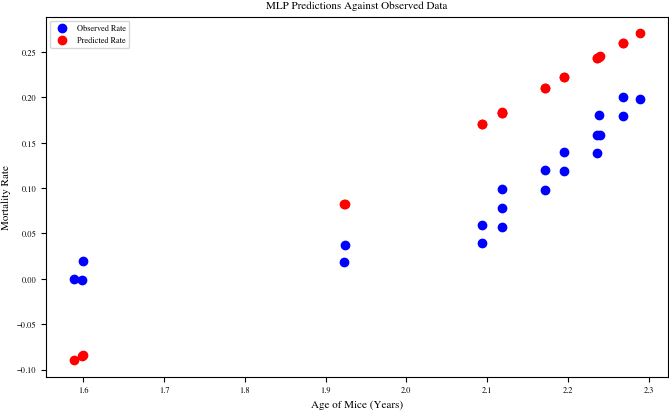

In [11]:
## Model against Observed

ages_plot = calculate_ages(female_dataset["mTERT,Rapamycin,HSCs,Gal-Nav"])
mortality_rate = calculate_mortality_rate(female_dataset["mTERT,Rapamycin,HSCs,Gal-Nav"])

mr_predictions = make_predictions(model, female_dataset["mTERT,Rapamycin,HSCs,Gal-Nav"]["x"], [1,1,1,1])

plt.scatter(ages_plot, mortality_rate, label='Observed Rate', color='blue')
plt.scatter(ages_plot, mr_predictions, label='Predicted Rate', color='red')

plt.xlabel('Age of Mice (Years)')
plt.ylabel('Mortality Rate')
plt.title('MLP Predictions Against Observed Data')
plt.legend()
plt.show()


In [12]:
# Plot all the combos

/var/folders/4n/gxws16r93l162vycp0sjx3940000gn/T/ipykernel_73405/2206238877.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


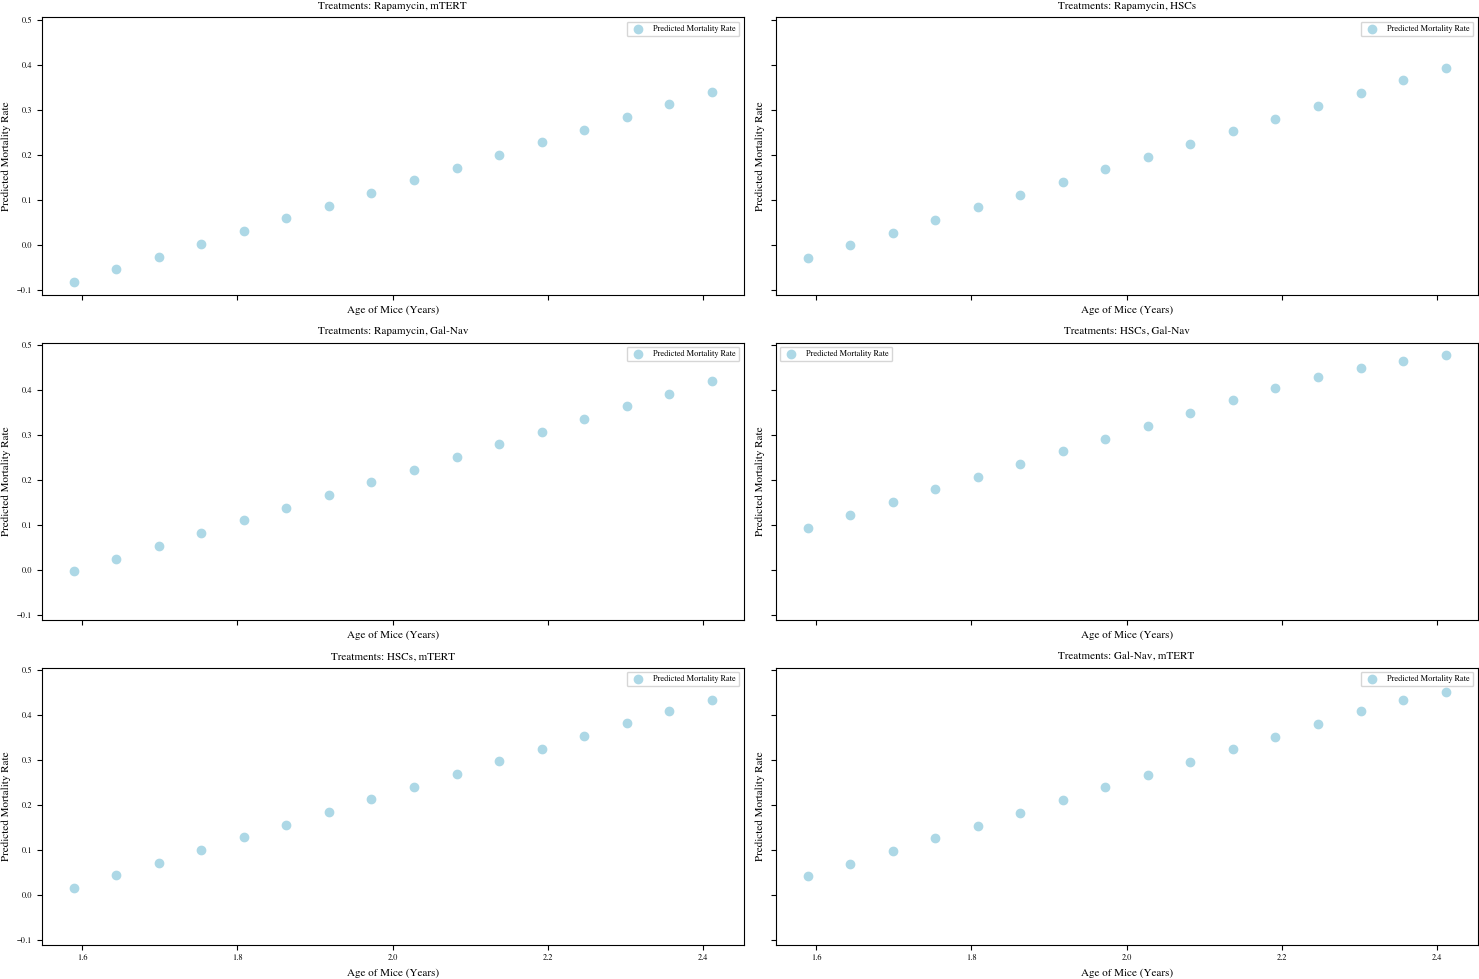

In [13]:
all_combos = [[1, 0, 0, 1], [1, 1, 0, 0], [1, 0, 1, 0], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 1, 1]]
ages_to_predict = np.arange(580, 900, 20)

# Define the number of rows and columns for the subplot grid
num_rows = 3  # You can adjust this based on your preference
num_cols = 2

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10),sharex=True, sharey=True)
# Flatten the axs array to make it easier to iterate over
axs = axs.flatten()
# Treatment labels
treatment_labels = ['Rapamycin', 'HSCs', 'Gal-Nav', 'mTERT']

# Iterate through each treatment combination and plot the results in a subplot
for i, treatments in enumerate(all_combos):
    # Select the current subplot
    ax = axs[i]

    # Plot the model results in the current subplot
    plot_model_result(model, ages_to_predict, treatments, ax=ax)

    # Add a title for better identification of each subplot
    ax.set_title(f'Treatments: {", ".join([treatment_labels[i] for i in range(len(treatments)) if treatments[i] == 1])}')


# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

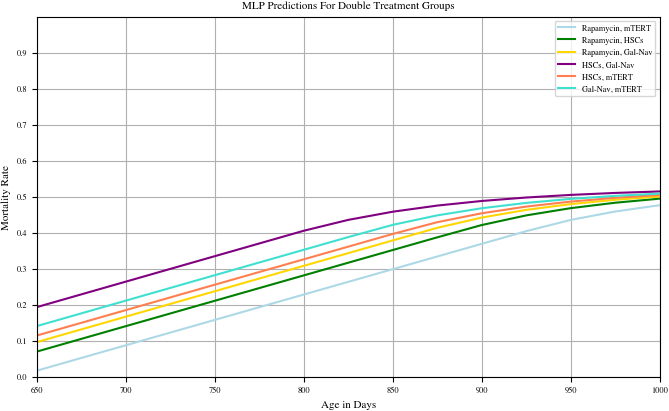

In [14]:
all_combos = [[1, 0, 0, 1], [1, 1, 0, 0], [1, 0, 1, 0], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 1, 1]]
ages_to_predict = np.arange(650, 1001, 25)

def plot_model_results(model, age, treatments):
    ages_plot = age

    # Define the number of rows and columns for the subplot grid
    num_rows = 1  # You can adjust this based on your preference
    num_cols = 1
    plt.rcParams.update(bundles.icml2022(column=COL_STATE, nrows=NROWS, ncols=NCOLS, usetex=USE_LATEX))
    fig, ax = plt.subplots(num_rows, num_cols)
    for i, treatment in enumerate(all_combos):
        # Plot the predicted mortality rates
        predictions = make_predictions(model, age, treatment)
        ax.plot(ages_plot, predictions, linestyle = "-",label=", ".join([treatment_labels[i] for i in range(len(treatment)) if treatment[i] == 1]), color=COLOR_MAP[i])
    
    ax.set_xlim(650, 1000)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(650, 1001, 50))
    ax.set_yticks(np.arange(0, 1, 0.1))
    ax.grid(True)
    ax.set_xlabel('Age in Days')
    ax.set_ylabel('Mortality Rate')
    ax.set_title("MLP Predictions For Double Treatment Groups")
    ax.legend(loc='best')
    fig.savefig("../fig/MLP_predictions.pdf")

plot_model_results(model, ages_to_predict, all_combos)

# Predict best combination

Since in the study these treatment combinations are tested:

- No treatments
- All single treatments
- All combinations of three treatments
- All treatments combined

we can directly calculate the best reduction in mortality rate for those treatments from the observed data.

Therefore we only need to calculate the reduction in mortality rate for our predicted combinations of two treatments.
Following that we can determine which treatment combination seems to lead to the best decline in mortality.

In [15]:
# Step 1: Calculate predictions for the 6 treatment combinations
all_combos = {'Rapamycin,mTERT' : [1, 0, 0, 1],"Rapamycin,HSCs": [1, 1, 0, 0],"Rapamycin,Gal-Nav": [1, 0, 1, 0],
              "HSCs,Gal-Nav":[0, 1, 1, 0],"HSCs,mTERT": [0, 1, 0, 1],"Gal-Nav,mTERT": [0, 0, 1, 1]}
ages_to_predict = np.arange(580, 900, 20)
def calculate_predictions(model, ages, treatments):
    # Iterate through each treatment combination and save the results
    predictions = {}
    for key, treatment in (treatments).items():
        predictions[key] = [make_predictions(model, ages, treatment), ages_to_predict[len(ages_to_predict)-1] - ages_to_predict[0]]
    return predictions


combination_predictions = calculate_predictions(model, ages_to_predict, all_combos)
combination_predictions


{'Rapamycin,mTERT': [[-0.0822506695985794,
   -0.05399017035961151,
   -0.02574346959590912,
   0.0024908632040023804,
   0.030714377760887146,
   0.05892805755138397,
   0.0871337503194809,
   0.11533103883266449,
   0.14352189004421234,
   0.17170663177967072,
   0.19988499581813812,
   0.22805820405483246,
   0.25622689723968506,
   0.28439080715179443,
   0.31255006790161133,
   0.3407061696052551],
  300],
 'Rapamycin,HSCs': [[-0.02926410734653473,
   -0.0009877532720565796,
   0.027275189757347107,
   0.05552546679973602,
   0.08376474678516388,
   0.11199469864368439,
   0.14021603763103485,
   0.16842900216579437,
   0.19663502275943756,
   0.22483481466770172,
   0.2530277967453003,
   0.28121572732925415,
   0.3093985319137573,
   0.33757591247558594,
   0.3657493591308594,
   0.39391815662384033],
  300],
 'Rapamycin,Gal-Nav': [[-0.0031036585569381714,
   0.025213584303855896,
   0.05351616442203522,
   0.08180521428585052,
   0.11008186638355255,
   0.1383478194475174,
   0

In [16]:
# Step 2: merge with observed data
observed_mortality_rates = {}
for key, mr in female_dataset.items():
    observed_mortality_rates[key] = [ calculate_mortality_rate(mr), abs(max(mr['x']) - min(mr['x']))]
 
all_combinations = observed_mortality_rates | combination_predictions
all_combinations

{'Rapamycin,HSCs,Gal-Nav': [array([ 0.        , -0.00225243,  0.02301362,  0.02032222,  0.04094537,
          0.06404404,  0.04397605,  0.08456521,  0.06348435,  0.08579041,
          0.10842032,  0.12918809,  0.10861119,  0.12918809,  0.15083903,
          0.17250737,  0.15214891,  0.1930121 ,  0.17454699,  0.21656703,
          0.19481656,  0.21702135,  0.24041964,  0.26021756,  0.23872166,
          0.28324609,  0.2605155 ,  0.27979871,  0.30443091,  0.32577817,
          0.30537334,  0.32724089]),
  283.26193162070035],
 'mTERT': [array([ 0.        , -0.00332944,  0.02055767,  0.04250078,  0.02017533,
          0.06340238,  0.04453158,  0.08402736,  0.06403147,  0.08467344,
          0.1067332 ,  0.10703085,  0.12960082,  0.15041402,  0.1285794 ,
          0.17317028,  0.15305979,  0.17317028,  0.1953728 ,  0.19565739,
          0.21568263,  0.19475726,  0.21568263,  0.23878993,  0.23781226,
          0.25996083,  0.28104035,  0.26105016,  0.30467848,  0.28104035,
          0.30288

In [28]:
# Step 3: Calculate (monthly) rate of change of each combination 
def calculate_rate_of_change(mortality_rates):
    rate_of_change = {}
    for key, value in mortality_rates.items():
        time_in_days = value[1]
        time_in_months = time_in_days
        pred = value[0]
        rate_of_change[key] = abs( pred[ len(pred)-1 ] - pred[0] ) / time_in_months
    return rate_of_change


rate_of_change = calculate_rate_of_change(all_combinations)
rate_of_change["None"] = rate_of_change.pop("")
rate_of_change

{'Rapamycin,HSCs,Gal-Nav': 0.0011552589922518835,
 'mTERT': 0.0013693356864079265,
 'Rapamycin': 0.0012446218370697093,
 'mTERT,Rapamycin,Gal-Nav': 0.000927578292331576,
 'HSCs': 0.0019798290710936663,
 'mTERT,Rapamycin,HSCs,Gal-Nav': 0.0007759118598675495,
 'mTERT,Rapamycin,HSCs': 0.0010174017438793574,
 'Gal-Nav': 0.0019755849554344137,
 'mTERT,HSCs,Gal-Nav': 0.0012926318158225627,
 'Rapamycin,mTERT': 0.0014098561306794485,
 'Rapamycin,HSCs': 0.001410607546567917,
 'Rapamycin,Gal-Nav': 0.0014090201755364736,
 'HSCs,Gal-Nav': 0.001279821147521337,
 'HSCs,mTERT': 0.0013973988592624665,
 'Gal-Nav,mTERT': 0.0013698390622933706,
 'None': 0.0021676824483576446}

In [29]:
# Step 4: Lowest RoC = slowest increasing mortality = best combination
def find_lowest_rate_of_change(rate_of_change_dict):
    min = 10e9
    for key, value in rate_of_change_dict.items():
        if value < min:
            roc = {}
            roc[key] = value
            min = value
    return roc
    
best_mortality_decrease = find_lowest_rate_of_change(rate_of_change)
best_mortality_decrease

{'mTERT,Rapamycin,HSCs,Gal-Nav': 0.0007759118598675495}

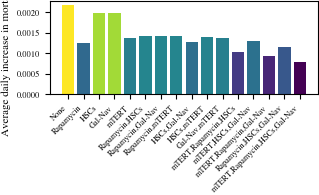

In [34]:
# Define custom key order
custom_order = ['None', 'Rapamycin', 'HSCs', 'Gal-Nav', 'mTERT',
                'Rapamycin,HSCs', 'Rapamycin,Gal-Nav', 'Rapamycin,mTERT', 'HSCs,Gal-Nav', 'HSCs,mTERT', 'Gal-Nav,mTERT',
                'mTERT,Rapamycin,HSCs', 'mTERT,HSCs,Gal-Nav', 'mTERT,Rapamycin,Gal-Nav', 'Rapamycin,HSCs,Gal-Nav',
                'mTERT,Rapamycin,HSCs,Gal-Nav']

# Function to return the index of the key in custom order
def get_custom_order(key):
    return custom_order.index(key)

# Sort dictionary based on custom key order
sorted_dict = dict(sorted(rate_of_change.items(), key=lambda item: get_custom_order(item[0])))


# Extract data for plotting
labels, values = zip(*sorted_dict.items())

# Create barplot
#plt.figure(figsize=(12, 6))
plt.rcParams.update(bundles.icml2022(column='half', nrows=NROWS, ncols=NCOLS, usetex=USE_LATEX))
cmap = plt.cm.viridis
norm = plt.Normalize(min(values), max(values))
colors = cmap(norm(values))
bars = plt.bar(labels, values, color=colors)
#plt.colorbar(orientation='horizontal')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Average daily increase in mortality rate')

#plt.title('Monthly Mortality Increase')
#plt.tight_layout()

# Save the plot
plt.savefig('../fig/2401_005_mlp_predictions.pdf')

In [ ]:
''## Calculate Average validation loss across 20 different variants of train/val datasets to assess model 
# Set seeds for reproducability
seeds = np.arange(10, 50, 2)

validation_errors = []
for seed in seeds:  
    validation_errors.append(train_model(seed,10)[1])
validation_errors

In [ ]:
np.mean(validation_errors)

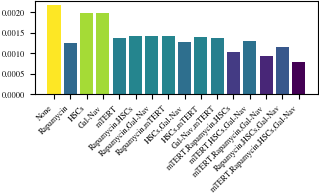

In [43]:
# Define custom key order
custom_order = ['None', 'Rapamycin', 'HSCs', 'Gal-Nav', 'mTERT',
                'Rapamycin,HSCs', 'Rapamycin,Gal-Nav', 'Rapamycin,mTERT', 'HSCs,Gal-Nav', 'HSCs,mTERT', 'Gal-Nav,mTERT',
                'mTERT,Rapamycin,HSCs', 'mTERT,HSCs,Gal-Nav', 'mTERT,Rapamycin,Gal-Nav', 'Rapamycin,HSCs,Gal-Nav',
                'mTERT,Rapamycin,HSCs,Gal-Nav']

# Function to return the index of the key in custom order
def get_custom_order(key):
    return custom_order.index(key)

# Sort dictionary based on custom key order
sorted_dict = dict(sorted(rate_of_change.items(), key=lambda item: get_custom_order(item[0])))


# Extract data for plotting
labels, values = zip(*sorted_dict.items())

# Create barplot
#plt.figure(figsize=(12, 6))
plt.rcParams.update(bundles.icml2022(column='half', nrows=NROWS, ncols=NCOLS, usetex=USE_LATEX))
cmap = plt.cm.viridis
norm = plt.Normalize(min(values), max(values))
colors = cmap(norm(values))
bars = plt.bar(labels, values, color=colors)
#plt.colorbar(orientation='horizontal')

plt.xticks(rotation=45, ha='right')
#plt.ylabel('Average daily \n increase in \n mortality rate')

#plt.title('Monthly Mortality Increase')
#plt.tight_layout()

# Save the plot
plt.savefig('../fig/2401_005_mlp_predictions.pdf')